<a href="https://colab.research.google.com/github/alibgil/CodingDojo-DataScience/blob/main/Sales_predictions_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de ventas**

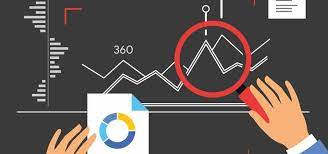

Predicción de ventas para productos alimenticios vendidos en diversas tiendas.  El objetivo de esto es ayudar al minorista a comprender las propiedades de los productos y los puntos de venta que desempeñan un papel crucial en el aumento de las ventas.

| Nombre de la variable     | Descripción                                                                                                           |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------|
| Item_Identifier           | Identificación única del producto                                                                                     |
| Item_Weight               | Peso del producto                                                                                                     |
| Item_Fat_Content          | Si el producto es bajo en grasa o regular                                                                             |
| Item_Visibility           | El porcentaje de la superficie total de exposición de todos los productos de una tienda asignada al producto concreto |
| Item_Type                 | La categoría a la que el producto pertenece                                                                           |
| Item_MRP                  | Precio máximo de venta al público (precio de catálogo) del producto                                                   |
| Outlet_Identifier         | Identificación única de la tienda                                                                                     |
| Outlet_Establishment_Year | El año cuando se estableció la tienda                                                                                 |
| Outlet_Size               | El tamaño de la tienda con respecto a la superficie                                                                   |
| Outlet_Location_Type      | El tipo de área donde está ubicada la tienda                                                                          |
| Outlet_Type               | Si el marcado es un almacén o algún tipo de supermercado                                                              |
| Item_Outlet_Sales         | Ventas del producto en la tienda particular Es la variable objetivo a predecir                                        |

In [85]:
#Librerías
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor

In [35]:
#Base de datos
from google.colab import drive
drive.mount('/content/drive')

filename= '/content/drive/MyDrive/BootCamp/sales_predictions.csv'

df = pd.read_csv(filename)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### I.- Análisis Exploratorio

**Manipulación de datos**

In [36]:
#inspect the data
print(df.info(), '\n')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None 

Item_Identifier                 0
Item

Podemos ver una mezcla de tipos de datos con datos faltantes en columnas flotantes y columnas de objetos.

In [37]:
#Identificación categorías
cat_var = [key for key in dict(df.dtypes) if dict(df.dtypes)[key] in ['object'] ]
for cat in cat_var:
  print(df[cat].value_counts())

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64
Medium    279

Se procede a homologar las categorías de la variable Item_Fat_Content

In [38]:
df.replace({"LF": 'Low Fat', "low fat": 'Low Fat', "reg": 'Regular'}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Preprocesamiento**

Realizaremos una transformación de las variables categoricas y escalamiento de las númericas para tener un modelo de prodección mas acertado

In [62]:
# Instanciar selectores
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [64]:
# Instanciar transformadores
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

# Instancien el escalador
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [65]:
# Instanciar pipelines
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [60]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [70]:
#Instanciar transformador de columnas

# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessornum = make_column_transformer(number_tuple, category_tuple)
preprocessornum

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f657959d250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f657959da60>)])

In [72]:
# Escalar variable objetivo
scaler = StandardScaler()
# ajusten el escalador en los datos de entrenamiento
scaler.fit(df[['Item_Outlet_Sales']])
df['Item_Outlet_Sales'] = scaler.transform(df[['Item_Outlet_Sales']])
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,0.910601
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,-1.018440
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,-0.049238
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,-0.849103
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,-0.695373


In [73]:
# División de valores
X = df.drop('Item_Outlet_Sales', axis=1)
y = df['Item_Outlet_Sales']

In [74]:
#Transformar datos

# fit on train
preprocessor.fit(X)

X_processed = preprocessor.transform(X)
X_processed

array([[-0.84187169, -0.97073217,  1.74745381, ...,  1.        ,
         0.        ,  0.        ],
       [-1.64170589, -0.90811123, -1.48902325, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.09855449, -0.95691733,  0.01004021, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.53424315, -0.59978449, -0.89720755, ...,  1.        ,
         0.        ,  0.        ],
       [-1.33644372,  1.53287976, -0.60797692, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.45963367, -0.41193591, -1.05226104, ...,  1.        ,
         0.        ,  0.        ]])

In [75]:
# Comprobación de los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_processed).sum().sum(), 'missing values data')
print('\n')
print('All data in df are', X_processed.dtype)
print('\n')
print('shape of data is', X_processed.shape)
print('\n')

0 missing values data


All data in df are float64


shape of data is (8523, 1601)




Finalmente evidenciamos que nuestros datos estan completos, sin faltantes

In [76]:
#Concatenar todas las características de vuelta a un DataFrame.
df_processed = pd.DataFrame(X_processed)
df_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600
0,-0.841872,-0.970732,1.747454,0.139541,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.641706,-0.908111,-1.489023,1.334103,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.098554,-0.956917,0.010040,0.139541,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.500838,-1.281758,0.660050,0.020085,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.929428,-1.281758,-1.399220,-1.293934,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [78]:
#Dividir modelos
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, random_state=42)

### II.- Modelos

Para la predicción de ventas para productos alimenticios vendidos en diversas tiendas, probaremos varios modelos y se verificará cual es el que mas nos conviene

**Regresión Lineal**

In [79]:
#Instanciar modelo regresión lineal
reg = LinearRegression()

#Ajustar modelo
reg.fit(X_train,y_train)

LinearRegression()

In [80]:
# Obtengan las predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train)
# Obtengan las predicciones del conjunto de prueba
test_preds = reg.predict(X_test)
test_preds

array([-0.76171875, -0.64453125, -0.515625  , ...,  1.2421875 ,
       -0.109375  ,  0.671875  ])

In [81]:
#Medición del rendimiento del modelo
train_score = reg.score(X_train, y_train)
test_score = reg.score(X_test, y_test)

print(train_score, '\n')

print(test_score)

0.660419106866212 

-5.468466850539668e+21


El valor R^2 en nuestro conjunto de entrenamiento es 0.66, y el valor R^2 en nuestro conjunto de prueba es -5.46.  En este caso, nuestras puntuaciones de entrenamiento y prueba estan muy alejadas, lo que significa que nuestro modelo esta "sobreajustado", dado que nuestro modelo funciona en nuestros datos de entrenamiento, pero falla en hacer buenas predicciones en los datos de prueba ocultos.

In [83]:
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print(rmse_train)
print(rmse_test)

0.5874850638405851
71982369577.94118


Con el RMSE confirmamos el sobreajuste del modelo y que no es una buena opción para la predicción de datos

**Árbol de regresión**

In [87]:
#Instanciar modelo
dec_tree = DecisionTreeRegressor(random_state = 42)

#Entrenar modelo
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [113]:
#Prediccoón
train_preds_AR = dec_tree.predict(X_train)
test_preds_AR = dec_tree.predict(X_test)
test_preds_AR

array([-0.80618338, -0.54632465, -0.57071079, ...,  2.45570693,
       -0.78394322, -0.4952113 ])

In [92]:
# Rendimiento del modelo
train_score = dec_tree.score(X_train, y_train)
test_score = dec_tree.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.2288963805872095


In [96]:
#Hiperparámetros
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [98]:
# Parámetros para ajustar modelo
# Lista de valores a probar para max_depth:
max_depth_range = list(range(2, 36))# will try every value between 2 and 36
# Lista para almacenar la puntuación para cada valor de max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree.fit(X_train, y_train)
    score = dec_tree.score(X_test, y_test)
    r2.append(score)

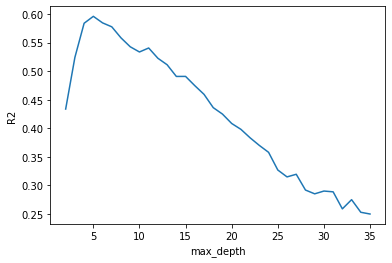

In [99]:
# Visualicen qué max_depth lleva a una puntuación R2 más alta
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [112]:
# Ejecutemos el modelo con nuestro valor optimizado para max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train, y_train)
train_5_score = dec_tree_5.score(X_train, y_train)
test_5_score = dec_tree_5.score(X_test, y_test)
print(train_5_score)
print(test_5_score)

0.6042066848171654
0.5960564372160062


Se observa que los resultados de entrenamiento y de prueba se acercaron (una señal que hemos reducido el sobreajuste) y que la puntuación de prueba ha mejorado.

In [116]:
#Nueva Prediccoón
train_preds_AR2 = dec_tree_5.predict(X_train)
test_preds_AR2 = dec_tree_5.predict(X_test)
test_preds_AR2

array([-0.60933489, -0.85040891, -0.85040891, ...,  0.8240239 ,
       -0.0927493 ,  0.19664966])

In [118]:
r2_train_AR = r2_score(y_train, train_preds_AR2)
r2_test_AR = r2_score(y_test, test_preds_AR2)

rmse_train_AR = np.sqrt(mean_squared_error(y_train, train_preds_AR2))
rmse_test_AR = np.sqrt(mean_squared_error(y_test, test_preds_AR2))



print("Árbol de regresión")
print("R2")
print(r2_train_AR)
print(r2_test_AR, '\n')

print("RMSE")
print(rmse_train_AR)
print(rmse_test_AR)

Árbol de regresión
R2
0.6042066848171654
0.5960564372160062 

RMSE
0.6342484783023514
0.6186623585968912


Finalmente se evidencia que los resultados de los modelos estan cercanos y el RMSE es bajo, lo cual nos indica la aproximidad de los valoes del modelo con los de predicción.

## Conclusiones

* Para un modelo con variables multiclase, se evidencia que el ideal es el Árbol de regresión, el cual con el ajuste de los hiperparpametros los valres de entretamiento y prueba estan cercanos y cuenta con un RMSE bajo.

* Finalmente, se presenta al cliente el modelo que nos genera la predicción de ventas para productos alimenticios vendidos en diversas tiendas, con lo cual podrán entender como actuar en los diferentes sectores cuales son los productos que se dben ofrecer y tener una referencia de coo impulsar otros.

## Recomendaciones

* Aunque nuestro resultado muestra que el modelo no esta sobreajustado, se recomienda analizar otros modelos multiclase que nos generen un rendimiento mas cercano a 1.

## Referencias

* [Curso MAT281_2022](https://github.com/fralfaro/MAT281_2022)
* [Curso CodingDojo-DataScience](https://github.com/fralfaro/CodingDojo-DataScience)